# Import Library

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19, MobileNetV2 ,InceptionV3
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import keras_tuner as kt

# Read Dataset

In [32]:
df = pd.read_csv("data.csv")
df["file_path"] = df["mood"]+'/'+df["filename"].str.split(".",expand=True)[0]+".png"

In [33]:
df.head()

,filename,mood,file_path
0,A Song For Mama_0.wav,Romance,Romance/A Song For Mama_0.png
1,A Song For Mama_1.wav,Romance,Romance/A Song For Mama_1.png
2,A Song For Mama_2.wav,Romance,Romance/A Song For Mama_2.png
3,A Song For Mama_3.wav,Romance,Romance/A Song For Mama_3.png
4,A Song For Mama_4.wav,Romance,Romance/A Song For Mama_4.png


In [34]:
df["mood"].value_counts()

Romance    395
Party      368
Chill      347
Anxious    343
Focus      301
Sad        271
Name: mood, dtype: int64

# Define Constant

In [35]:
base_dir = "spectogram/"
IMAGE_SIZE = 224
BATCH_SIZE = 128

# Split Dataset

In [36]:
# Train 0.75
# Validate 0.15
# Test 0.10
df_train,  test_df = train_test_split(df,train_size=0.9,random_state=1941,stratify=df['mood'])
train_df, val_df = train_test_split(df_train,test_size=1/6,random_state=1941,stratify=df_train['mood'])

# Load image to generator

In [37]:
from keras_preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1./255,)

train_data = train_image_generator.flow_from_dataframe(
    train_df,
    directory=base_dir,
    x_col="file_path",
    y_col="mood",
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 1518 validated image filenames belonging to 6 classes.


In [38]:
val_image_generator = ImageDataGenerator(rescale=1./255)

val_data = val_image_generator.flow_from_dataframe(
    val_df,
    directory=base_dir,
    x_col="file_path",
    y_col="mood",
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 304 validated image filenames belonging to 6 classes.


In [39]:
test_image_generator = ImageDataGenerator(rescale=1./255)

test_data = test_image_generator.flow_from_dataframe(
    test_df,
    directory=base_dir,
    x_col="file_path",
    y_col="mood",
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 203 validated image filenames belonging to 6 classes.


## Check Class indices

In [40]:
train_data.class_indices

{'Anxious': 0, 'Chill': 1, 'Focus': 2, 'Party': 3, 'Romance': 4, 'Sad': 5}

# Create model

In [41]:
def get_mobilenet_model(hp):
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  headModel = baseModel.output
  reduction_type = hp.Choice('reduction_type', ['flatten', 'avg'])
  if reduction_type == 'flatten':
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
  else:
    headModel = GlobalAveragePooling2D()(headModel)
  denseLayers = [
    hp.Int('num_dense_units1', min_value=32, max_value=512, step=32),
    hp.Int('num_dense_units2', min_value=32, max_value=512, step=32),
    hp.Int('num_dense_units3', min_value=32, max_value=512, step=32)
  ]
  for i in range(hp.Int('num_dense_layers', min_value=1, max_value=3, step=1)):
    headModel = Dense(units=denseLayers[i], activation="relu")(headModel)
  headModel = Dropout(hp.Choice('dropout_rate', [0.2, 0.25, 0.3, 0.4, 0.5]))(headModel)
  headModel = Dense(hp.Int('num_last_dense', min_value=32, max_value=64, step=16), activation="relu")(headModel)
  headModel = Dense(6, activation="softmax")(headModel)
  model = Model(inputs=baseModel.input, outputs=headModel)
  for layer in baseModel.layers:
    layer.trainable = False
  model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])
  return model

In [42]:
model = get_mobilenet_model(kt.HyperParameters())
model_name = "model.h5"

In [43]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "models/"+model_name, save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [44]:
tuner = kt.RandomSearch(
    get_mobilenet_model,
    objective='val_accuracy', 
    max_trials=50,
    overwrite=True,
    project_name='melodistic-project') 

In [45]:
tuner.search(train_data, epochs=10, validation_data=val_data, callbacks=[model_checkpoint, early_stopping])


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
reduction_type    |avg               |?                 
num_dense_units1  |128               |?                 
num_dense_units2  |160               |?                 
num_dense_units3  |224               |?                 
num_dense_layers  |1                 |?                 
dropout_rate      |0.5               |?                 
num_last_dense    |32                |?                 

Epoch 1/10


2022-03-20 00:31:54.802567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 1.7646 - accuracy: 0.2833

2022-03-20 00:32:03.042572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 11s 777ms/step - loss: 1.7646 - accuracy: 0.2833 - val_loss: 1.4264 - val_accuracy: 0.4507
Epoch 2/10
12/12 [==============================] - 10s 760ms/step - loss: 1.4299 - accuracy: 0.4157 - val_loss: 1.2345 - val_accuracy: 0.4967
Epoch 3/10
12/12 [==============================] - 9s 716ms/step - loss: 1.2576 - accuracy: 0.4743 - val_loss: 1.1319 - val_accuracy: 0.5263
Epoch 4/10
12/12 [==============================] - 9s 732ms/step - loss: 1.1707 - accuracy: 0.5303 - val_loss: 1.0276 - val_accuracy: 0.6053
Epoch 5/10
12/12 [==============================] - 8s 702ms/step - loss: 1.0890 - accuracy: 0.5468 - val_loss: 0.9687 - val_accuracy: 0.6217
Epoch 6/10
12/12 [==============================] - 8s 688ms/step - loss: 1.0179 - accuracy: 0.5916 - val_loss: 0.9258 - val_accuracy: 0.6414
Epoch 7/10
12/12 [==============================] - 9s 719ms/step - loss: 0.9630 - accuracy: 0.6159 - val_loss: 0.8948 - val_accuracy: 0.6414
Epoch 8/10
12/1

In [ ]:
best_model = tuner.get_best_models()[0]
EPOCHS = 100
history = best_model.fit(train_data, epochs=EPOCHS, validation_data=val_data, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100


2022-03-20 00:27:22.885656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 0.6649 - accuracy: 0.7398

2022-03-20 00:27:31.007259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 11s 743ms/step - loss: 0.6649 - accuracy: 0.7398 - val_loss: 0.7681 - val_accuracy: 0.6809
Epoch 2/100
12/12 [==============================] - 8s 670ms/step - loss: 0.5801 - accuracy: 0.7773 - val_loss: 0.8413 - val_accuracy: 0.6743
Epoch 3/100
12/12 [==============================] - 8s 674ms/step - loss: 0.4617 - accuracy: 0.8307 - val_loss: 0.8080 - val_accuracy: 0.7007
Epoch 4/100
12/12 [==============================] - 8s 667ms/step - loss: 0.4440 - accuracy: 0.8300 - val_loss: 0.8498 - val_accuracy: 0.6776
Epoch 5/100
12/12 [==============================] - 8s 698ms/step - loss: 0.3837 - accuracy: 0.8505 - val_loss: 0.8694 - val_accuracy: 0.7007
Epoch 6/100
12/12 [==============================] - 8s 662ms/step - loss: 0.3102 - accuracy: 0.8874 - val_loss: 0.9976 - val_accuracy: 0.7072
Epoch 7/100
12/12 [==============================] - 8s 628ms/step - loss: 0.2755 - accuracy: 0.9051 - val_loss: 0.8308 - val_accuracy: 0.7336
Epoch 8/10

# Save Model

In [ ]:
best_model.save("models/"+model_name)

# Load Model

In [ ]:
model = load_model("models/"+model_name)

# Evaluate Model

In [ ]:
import os
confusion_matrix_s = np.zeros(36).reshape(6,6)
true = 0
class_labels = list(train_data.class_indices.keys())
count = 0
for i in test_df.itertuples():
    img = tf.keras.preprocessing.image.load_img(
        os.path.join(base_dir,i[3]), target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255
    img_array = img_array.reshape(1,IMAGE_SIZE,IMAGE_SIZE,3)
    predictions = model.predict(img_array)
    pred_class = class_labels[np.argmax(predictions)]   
    row = class_labels.index(pred_class)
    col = class_labels.index(i[2])
    confusion_matrix_s[row][col] += 1
    if pred_class == i[2]:
        true+=1
    count += 1
    if count % 10 == 0:
        print("Done: ",count, "Acc:", round(true/count,4))
print("Accuracy: ", round(true/count,4))

2022-03-20 00:30:19.749530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Done:  10 Acc: 0.7
Done:  20 Acc: 0.75
Done:  30 Acc: 0.8
Done:  40 Acc: 0.775
Done:  50 Acc: 0.76
Done:  60 Acc: 0.7333
Done:  70 Acc: 0.7286
Done:  80 Acc: 0.7375
Done:  90 Acc: 0.7222
Done:  100 Acc: 0.73
Done:  110 Acc: 0.7182
Done:  120 Acc: 0.7417
Done:  130 Acc: 0.7538
Done:  140 Acc: 0.7571
Done:  150 Acc: 0.76
Done:  160 Acc: 0.7688
Done:  170 Acc: 0.7765
Done:  180 Acc: 0.7833
Done:  190 Acc: 0.7789
Done:  200 Acc: 0.785
Accuracy:  0.7833


Accuracy:  0.7832512315270936


/var/folders/q1/qjttjhc15mb146h6q363vh_80000gn/T/ipykernel_1301/980666082.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["",*class_labels])
/var/folders/q1/qjttjhc15mb146h6q363vh_80000gn/T/ipykernel_1301/980666082.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["",*class_labels])


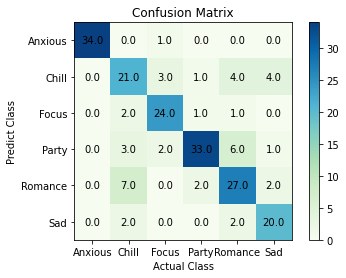

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title("Confusion Matrix")
heatmap = ax.matshow(confusion_matrix_s,cmap='GnBu')
plt.xlabel("Actual Class")
plt.ylabel("Predict Class")
plt.colorbar(heatmap)
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(["",*class_labels])
ax.set_yticklabels(["",*class_labels])
for (i, j), z in np.ndenumerate(confusion_matrix_s):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
accuracy = np.trace(confusion_matrix_s)/np.sum(confusion_matrix_s)
print("Accuracy: ", accuracy)